# 42186 Model-based machine learning
- Matteo Piccagnoni s232713
- Gabriel Lanaro s233541
- Manuel Lovo s...

# Topic-aware SPAM message classification in Bayesian setup

## 1. Introduction


Spam messages are annoying, and sometimes dangerous. Classifying them correctly is important, but we often ignore one key aspect: how confident are we in the predictions? 

In this project, we take a more thoughtful approach to spam detection by combining two powerful tools: **topic modeling** and **Bayesian inference**. 

First, we use **Latent Dirichlet Allocation (LDA)** to discover the hidden topics inside SMS messages, this gives us a better understanding of what the messages are about. 
Then, instead of using a standard classifier, we go full **Bayesian** with a **logistic regression model** that doesn’t just make a prediction, it tells us how uncertain that prediction is. 

Everything is built using Pyro, a probabilistic programming library, which makes it easy to define the model and run inference using both SVI and MCMC. 

This notebook walks through the whole process step-by-step: from data cleaning to topic discovery to classification and uncertainty analysis. By the end, we’ll not only have a working spam filter: we will have one that knows when it’s unsure.

In [26]:
import pandas as pd
import numpy as np
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
from sklearn.feature_extraction.text import CountVectorizer
import torch
import pickle
import pyro
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

## 2. Dataset and Preprocessing

### 2.1 Dataset

In this project, the **SMS Spam Collection Dataset** has been used. It is a publicly available corpus hosted by the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/228/sms+spam+collection) which contains 5,574 English SMS messages, each labeled as either "ham" (legitimate) or "spam" (unwanted/unsolicited).

The messages were collected from a variety of sources:
Legitimate (ham) messages were gathered from public forums, SMS chat services, and volunteer contributors.
Spam messages were obtained from known spam databases and online archives of promotional SMS campaigns.

Each row in the dataset consists of two fields:
label: A string indicating whether the message is "ham" or "spam".
message: The actual content of the SMS text, written in natural language (English).

A few example rows:

| label | message |
|-------|---------|
| ham   | Are you coming to the party later? |
| spam  | You’ve won a £1000 cash prize! Text WIN to 80086 to claim now. |


The dataset is realistic and includes a broad range of message types, from casual conversations full of slang and abbreviations to marketing promos and scams that mimic legitimate offers. This makes it ideal for studying both semantic patterns (via topic modeling) and predictive classification (spam vs. ham). The class distribution is slightly imbalanced, with around 13% spam and 87% ham, which reflects real-world conditions.

Overall, this dataset offers a compact but rich playground for experimenting with natural language processing, especially when modeling uncertainty and interpretability, as we do in this Bayesian setup.

In [27]:
df_sms = pd.read_csv(
    "SMSSpamCollection", sep="\t", header=None, names=["label", "message"]
)
df_sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [28]:
df = df_sms.copy()

In [29]:
print(f"Dataset shape: {df_sms.shape}")
print("\nClass distribution:")
print(df_sms['label'].value_counts())

Dataset shape: (5572, 2)

Class distribution:
label
ham     4825
spam     747
Name: count, dtype: int64


In [30]:
if df_sms['label'].dtype in ['int64', 'int32', 'int', 'float', 'float64', 'float32']:
    # If numeric, assume 0=ham, 1=spam for visualization purposes
    print(f"\nSpam percentage: {df_sms['label'].mean() * 100:.2f}%")
    
    # For plotting, create a temporary string version
    plot_df = df_sms.copy()
    plot_df['label_str'] = plot_df['label'].map({0: 'ham', 1: 'spam'})
    
    # Set hue column for plots
    hue_col = 'label_str'
else:
    # If already string, compute binary representation for some calculations
    binary_labels = df_sms['label'].map({'ham': 0, 'spam': 1})
    print(f"\nSpam percentage: {binary_labels.mean() * 100:.2f}%")
    
    # Use original label column for plots
    plot_df = df_sms
    hue_col = 'label'


Spam percentage: 13.41%


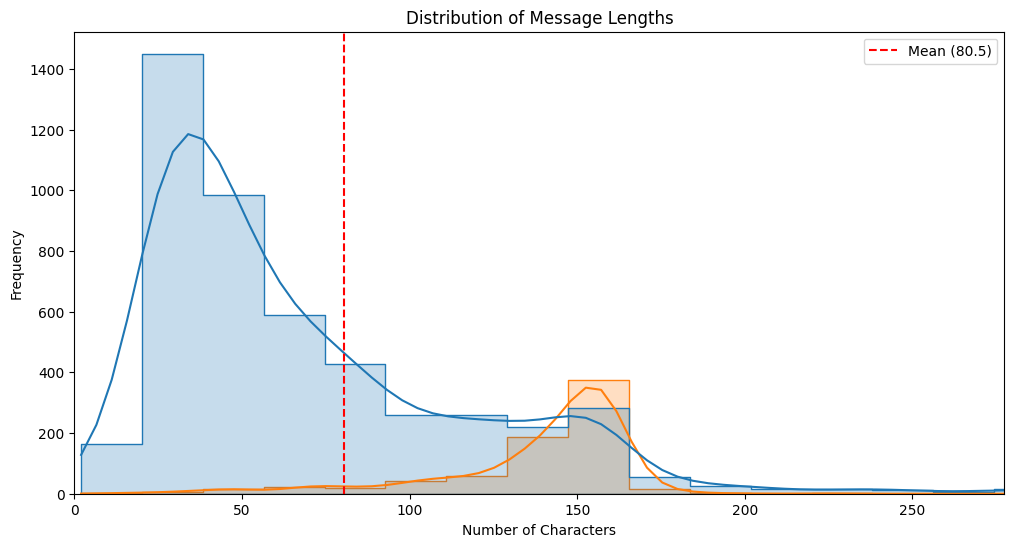

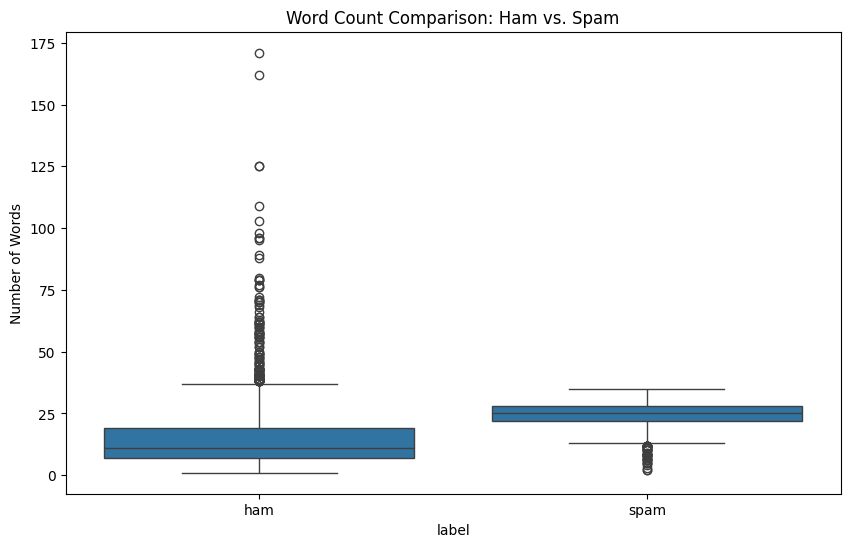

In [31]:
message_lengths = plot_df['message'].apply(len)
word_counts = plot_df['message'].apply(lambda x: len(str(x).split()))

# Add temporary columns for visualization
plot_df['message_length'] = message_lengths
plot_df['word_count'] = word_counts

# Message length histogram
plt.figure(figsize=(12, 6))
sns.histplot(data=plot_df, x='message_length', hue=hue_col, bins=50, kde=True, element='step')
plt.title('Distribution of Message Lengths')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.axvline(message_lengths.mean(), color='r', linestyle='--', label=f'Mean ({message_lengths.mean():.1f})')
plt.legend()
plt.xlim(0, message_lengths.quantile(0.99))  # Limit x-axis to exclude extreme outliers
plt.show()


plt.figure(figsize=(10, 6))
sns.boxplot(x=hue_col, y='word_count', data=plot_df)
plt.title('Word Count Comparison: Ham vs. Spam')
plt.ylabel('Number of Words')
plt.show()

### 2.2 Preprocessing

Before we can use the text messages in our models, we need to clean and prepare them. Raw SMS messages are often messy including typos, slang, special characters, and unnecessary words that can confuse a model. 
In this section, we’ll go through standard preprocessing steps like **lowercasing**, **removing stopwords**, **tokenizing**, and **stemming**. These transformations help reduce noise and bring the text into a more consistent format, which is especially important for tasks like topic modeling and classification. 

We’ll explain each step as we apply it in the code.

The following setup downloads the list of common English stopwords (like "the", "is", "and") from the NLTK library and initializes the stopword set and a Porter stemmer. These components will be used later to remove common words that carry little semantic meaning and to reduce words to their base form, respectively.

In [32]:
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lovomanuel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


The following function performs standard text preprocessing to prepare SMS messages for further analysis. It includes lowercasing, removal of URLs, numbers, and punctuation, followed by tokenization, stopword removal, and stemming. 
The result is a list of cleaned and normalized tokens for each message.

In [37]:
# Text Cleaning Function
def clean_message(text):
    text = text.lower()
    text = re.sub(r"http\S+|www.\S+", "", text)  # Remove URLs
    text = re.sub(r"\d+", "", text)  # Remove numbers
    text = text.translate(
        str.maketrans("", "", string.punctuation)
    )  # Remove punctuation
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

The cleaned tokenization function is applied to each message in the dataset using the apply method. A new column, "tokens", is created to store the resulting list of preprocessed tokens for each SMS message.

In [38]:
df["tokens"] = df["message"].apply(clean_message)
df.head()

,label,message,tokens
0,ham,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,"[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,ham,U dun say so early hor... U c already then say...,"[u, dun, say, early, hor, u, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...","[nah, dont, think, goes, usf, lives, around, t..."


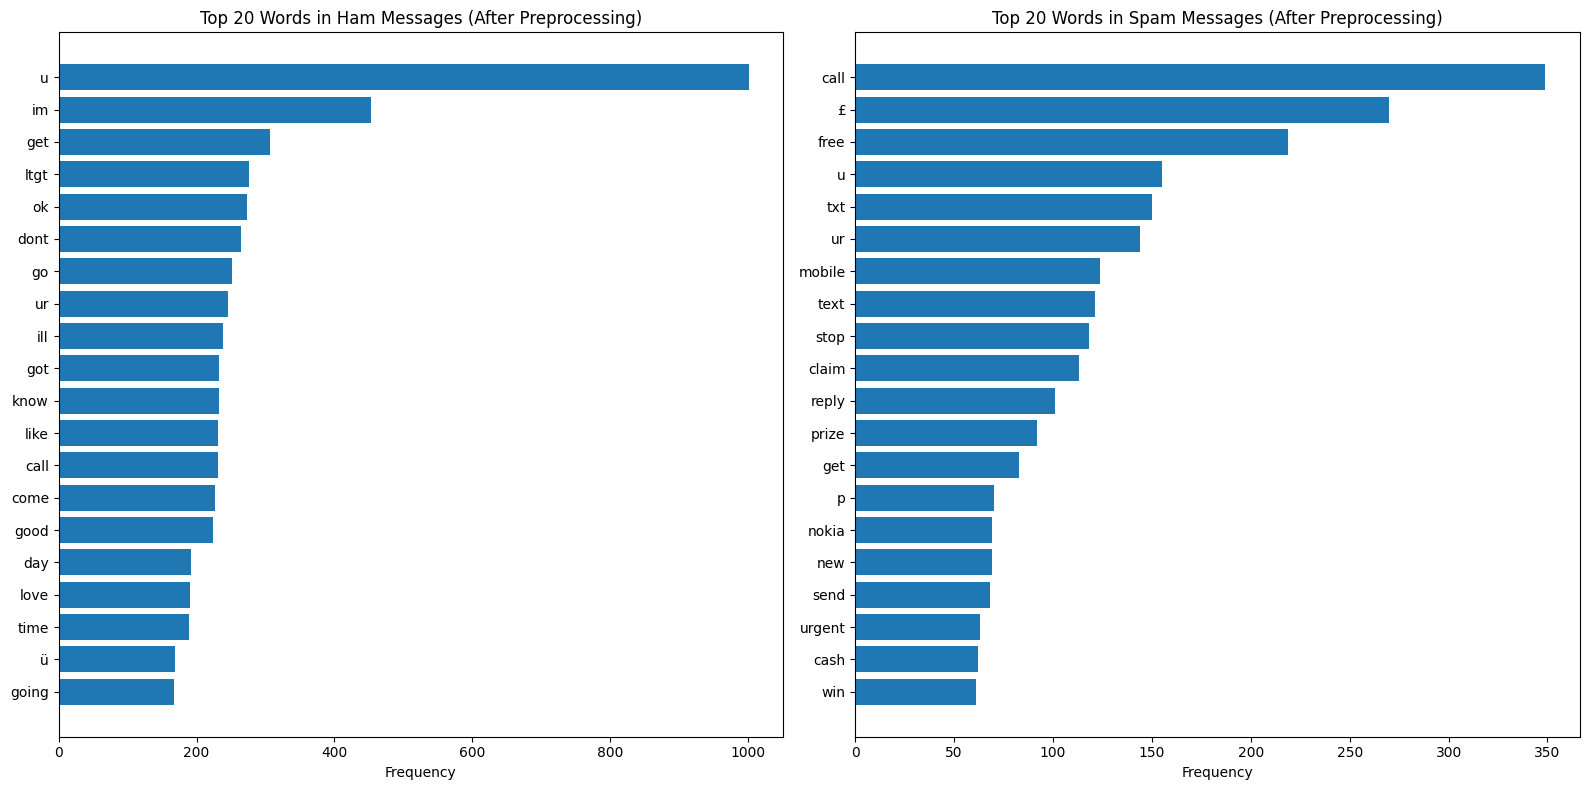

In [39]:
if hue_col == 'label':
    ham_tokens = [tokens for i, tokens in enumerate(df['tokens']) if df['label'].iloc[i] == 'ham']
    spam_tokens = [tokens for i, tokens in enumerate(df['tokens']) if df['label'].iloc[i] == 'spam']
else:
    ham_tokens = [tokens for i, tokens in enumerate(df['tokens']) if df['label_str'].iloc[i] == 'ham']
    spam_tokens = [tokens for i, tokens in enumerate(df['tokens']) if df['label_str'].iloc[i] == 'spam']

# Flatten the lists of tokens
ham_words = [word for sublist in ham_tokens for word in sublist]
spam_words = [word for sublist in spam_tokens for word in sublist]

# Count word frequencies
ham_word_counts = Counter(ham_words)
spam_word_counts = Counter(spam_words)

# Get top 20 words
top_ham_words = dict(ham_word_counts.most_common(20))
top_spam_words = dict(spam_word_counts.most_common(20))

# Plot top words for each class
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Ham words
ax1.barh(list(reversed(list(top_ham_words.keys()))), list(reversed(list(top_ham_words.values()))))
ax1.set_title('Top 20 Words in Ham Messages (After Preprocessing)')
ax1.set_xlabel('Frequency')

# Spam words
ax2.barh(list(reversed(list(top_spam_words.keys()))), list(reversed(list(top_spam_words.values()))))
ax2.set_title('Top 20 Words in Spam Messages (After Preprocessing)')
ax2.set_xlabel('Frequency')

plt.tight_layout()
plt.show()


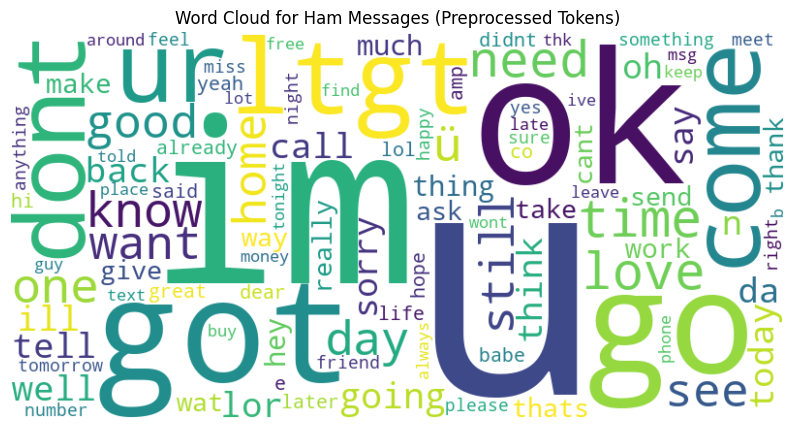

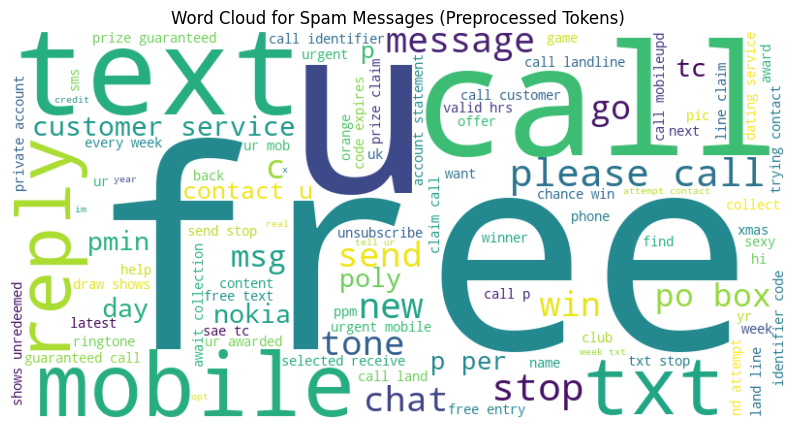

In [40]:
# 5. Word clouds for processed tokens
plt.figure(figsize=(10, 8))
ham_wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100, 
                          contour_width=3, contour_color='steelblue').generate(' '.join(ham_words))
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Ham Messages (Preprocessed Tokens)')
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 8))
spam_wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100,
                           contour_width=3, contour_color='firebrick').generate(' '.join(spam_words))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Spam Messages (Preprocessed Tokens)')
plt.axis('off')
plt.show()

In [41]:
stemmer = PorterStemmer()
def stem_tokens(tokens):
    return [stemmer.stem(token) for token in tokens]

df["stemmed_tokens"] = df["tokens"].apply(stem_tokens)
df.head()

,label,message,tokens,stemmed_tokens
0,ham,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazi, avail, bugi, n, gre..."
1,ham,Ok lar... Joking wif u oni...,"[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, wkly, comp, win, fa, cup, final,...","[free, entri, wkli, comp, win, fa, cup, final,..."
3,ham,U dun say so early hor... U c already then say...,"[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, earli, hor, u, c, alreadi, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...","[nah, dont, think, goes, usf, lives, around, t...","[nah, dont, think, goe, usf, live, around, tho..."


Above it is provides a quick preview of the structure and content of the DataFrame. At this stage, the output includes the raw message text, and the newly added tokens column, which contains the list of cleaned and preprocessed words extracted from each message. From the raw message to the tokenized version, the following elements were removed: URLs, numbers, punctuation, common stopwords, and words were reduced to their stemmed forms.

>Please notice that in the tokenized output, some words appear in their stemmed form (for example, "crazy" becomes "crazi"). This is a result of the Porter stemming algorithm, which reduces words to their morphological root to group similar terms together. While the resulting stems are not always real words, they help the model treat related terms (e.g., "crazy", "craziness") as the same feature.
It is also worth noting that abbreviations and slang (e.g., "u", "ur", "msg") were intentionally left unchanged. Although these do not follow standard grammar, they often carry important contextual or signals in SMS communication. Removing or expanding them could potentially obscure patterns that distinguish spam from ham in this domain.

In this step, the list of tokens for each message is joined back into a single string to prepare the input for CountVectorizer, which requires text input in string format. The CountVectorizer transforms the preprocessed messages into a bag-of-words (BoW) matrix, where each row represents a message and each column corresponds to a word in the vocabulary, with entries indicating the word count per message.
This BoW representation is a standard format for text modeling and is especially useful for Latent Dirichlet Allocation (LDA), which operates on document-word frequency data. The resulting matrix is converted into a PyTorch tensor to be compatible with Pyro, which is used for building and training the probabilistic topic model.

In [ ]:
texts_str = df["stemmed_tokens"].apply(
    lambda tokens: " ".join(tokens)
)  # Join tokens back to strings (for CountVectorizer)

print(texts_str.head())
# Create bag-of-words matrix

vectorizer = CountVectorizer()

X = vectorizer.fit_transform(texts_str)

X_tensor = torch.tensor(X.toarray(), dtype=torch.float)  # Convert to torch tensor

print("Input for LDA:", X_tensor.shape)  # should be (num_docs, vocab_size)

0    go jurong point crazi avail bugi n great world...
1                                ok lar joke wif u oni
2    free entri wkli comp win fa cup final tkt st m...
3                  u dun say earli hor u c alreadi say
4            nah dont think goe usf live around though
Name: stemmed_tokens, dtype: object
Input for LDA: torch.Size([5572, 7099])


The final print statement above shows the shape of the tensor, confirming that the data is now structured as (number of documents, vocabulary size), the expected input format for Pyro’s LDA model.

The example below illustrates the structure of the calculated data, providing a clearer understanding and overview of its format and content.

In [25]:
# Print first cleaned message as tokens
print("\nSample tokens:", df["tokens"].iloc[0])

# Print the BoW vector for the first message (as vector index → count)
print("Sample BoW row:", X_tensor[0].nonzero(as_tuple=True)[0].tolist())
print("Word counts:", X_tensor[0][X_tensor[0] > 0].tolist())

# Print the actual words from the vectorizer
vocab = vectorizer.get_feature_names_out()
print("Words in BoW row:", [vocab[i] for i in X_tensor[0].nonzero(as_tuple=True)[0]])


Sample tokens: ['go', 'jurong', 'point', 'crazi', 'avail', 'bugi', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amor', 'wat']
Sample BoW row: [212, 404, 790, 792, 1063, 1280, 2363, 2416, 2453, 3126, 3265, 4621, 6689, 6899]
Word counts: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Words in BoW row: ['amor', 'avail', 'buffet', 'bugi', 'cine', 'crazi', 'go', 'got', 'great', 'jurong', 'la', 'point', 'wat', 'world']


This code saves the DataFrame with tokens, the fitted vectorizer, and the bag-of-words matrix. These components will be reused in the LDA model to ensure consistency and reproducibility in the topic modeling process.

In [ ]:
# save the DataFrame with tokens
df.to_csv("lda_df.csv", index=False)

# save the vectorizer
with open("lda_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

# save bow matrix as numpy array
X_array = X.toarray().astype(np.float32)
np.savez_compressed("BoW_X_Array.npz", X_array)

print("File salvati:")
print("- lda_df.csv")
print("- lda_vectorizer.pkl")
print("- BoW_X_Array.npz")

## 3. LDA

**Introduction to LDA**

In [ ]:
import torch
import numpy as np
import pandas as pd
import pickle
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDelta

### 3.1 Topic Number Selection (K)

Since the number of topics *K* in **Latent Dirichlet Allocation (LDA)** must be specified in advance, we ran the Pyro-based LDA model across multiple candidate values (e.g. K = 5, 10, 15, ..., 90) and monitored the **Evidence Lower Bound (ELBO)** loss during training. 

For each value of *K*, we trained the model for a (smaller) fixed number of steps and recorded the final loss. The model with the lowest ELBO loss was selected as the best configuration. This approach allows us to balance model complexity and fit without relying on manual inspection or external coherence metrics.

This code has been ran in Kaggle Notebooks in order to exploit the GPU from Kaggle and get better and faster results.

In [ ]:
# Load Data
# X_array = np.load("/kaggle/input/bow-xarray/BoW_X_Array.npz")["arr_0"] # Uncomment this line if using Kaggle
X_array = np.load("BoW_X_Array.npz")["arr_0"]
X_tensor = torch.tensor(X_array, dtype=torch.float)
print("XArray loaded")

# Use GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

X_tensor = X_tensor.to(device)

num_docs, vocab_size = X_tensor.shape
K_values = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90]
results = []

for K in K_values:
    print(f"\n--- Training LDA with K = {K} ---")

    def lda_model(data):
        with pyro.plate("topics", K):
            topic_words = pyro.sample(
                "topic_words", dist.Dirichlet(torch.ones(vocab_size).to(device))
            )
        with pyro.plate("documents", num_docs):
            doc_topics = pyro.sample(
                "doc_topics", dist.Dirichlet(torch.ones(K).to(device))
            )
            word_dists = torch.matmul(doc_topics, topic_words)
            logits = torch.matmul(doc_topics, topic_words).log()
            pyro.sample(
                "doc_words", dist.Multinomial(total_count=100, logits=logits), obs=data
            )

    pyro.clear_param_store()
    guide = AutoDelta(lda_model)
    svi = SVI(lda_model, guide, pyro.optim.Adam({"lr": 0.01}), loss=Trace_ELBO())

    for step in range(500):
        loss = svi.step(X_tensor)

    posterior = guide()
    doc_topics = posterior["doc_topics"]
    topic_usage = doc_topics.sum(dim=0).detach().cpu().numpy()

    # Extra statistics
    loss_per_doc = loss / num_docs
    entropy = -(doc_topics * doc_topics.log()).sum(dim=1).mean().item()
    avg_active_per_doc = (doc_topics > 0.05).sum(dim=1).float().mean().item()
    num_active_topics = (topic_usage > 5.0).sum()

    results.append(
        {
            "K": K,
            "Final Loss": float(loss),
            "Loss per Doc": float(loss_per_doc),
            "Entropy": float(entropy),
            "Avg Active Topics/Doc": float(avg_active_per_doc),
            "Active Topics (global)": int(num_active_topics),
        }
    )

results_df = pd.DataFrame(results)
results_df.to_csv("results_k_selection.csv", index=False)

print("\n📊 K comparison results:")
print(results_df)

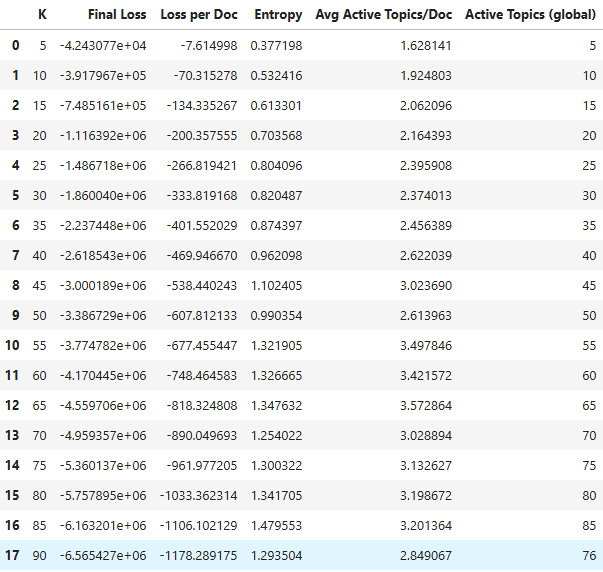

Why did we choose 60? ...

Introduction to Gensim and confirmation of our theory

In [ ]:
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt


def compute_coherence_values(dictionary, corpus, texts, start=5, limit=90, step=1):
    coherence_values = []
    models_list = []
    for num_topics in range(start, limit, step):
        model = models.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=42,
            passes=10,
            alpha="auto",
        )
        models_list.append(model)
        coherencemodel = CoherenceModel(
            model=model, texts=texts, dictionary=dictionary, coherence="c_v"
        )
        coherence_values.append(coherencemodel.get_coherence())
    return models_list, coherence_values


# Compute
model_list, coherence_values = compute_coherence_values(
    dictionary, corpus, texts, start=5, limit=90, step=1
)

# Plot
x = range(5, 90)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title("LDA Topic Coherence")
plt.grid()
plt.show()

### 3.2 Training the LDA Model with the selected K

Training properly and saving the results of the K=60 in a doc

In [ ]:
# Data loading
# X_array = np.load("/kaggle/input/bow-xarray/BoW_X_Array.npz")["arr_0"] # Uncomment this line if using Kaggle
X_array = np.load("BoW_X_Array.npz")["arr_0"]
X_tensor = torch.tensor(X_array, dtype=torch.float)

device = "cuda" if torch.cuda.is_available() else "cpu"
X_tensor = X_tensor.to(device)

num_docs, vocab_size = X_tensor.shape
K = 60

print(f"\n🚀 Training final LDA with K = {K} and 1000 steps...")


def lda_model(data):
    with pyro.plate("topics", K):
        topic_words = pyro.sample(
            "topic_words", dist.Dirichlet(torch.ones(vocab_size).to(device))
        )
    with pyro.plate("documents", num_docs):
        doc_topics = pyro.sample("doc_topics", dist.Dirichlet(torch.ones(K).to(device)))
        logits = torch.matmul(doc_topics, topic_words).log()
        pyro.sample(
            "doc_words", dist.Multinomial(total_count=100, logits=logits), obs=data
        )


pyro.clear_param_store()
guide = AutoDelta(lda_model)
svi = SVI(lda_model, guide, pyro.optim.Adam({"lr": 0.01}), loss=Trace_ELBO())

# Training
num_steps = 1000
for step in range(num_steps):
    loss = svi.step(X_tensor)
    if step % 100 == 0:
        print(f"[step {step}] loss = {loss:.2f}")

# Extract posterior distributions
posterior = guide()
doc_topics = posterior["doc_topics"].detach().cpu().numpy()

# Save topic proportions for each document
doc_topics_df = pd.DataFrame(doc_topics, columns=[f"topic_{i}" for i in range(K)])
doc_topics_df.to_csv("doc_topics_K60.csv", index=False)
print("✅ doc_topics saved in 'doc_topics_K60.csv'")

### 3.3 Analysis of results

Little data analysis about the data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the topic proportions matrix
doc_topics = pd.read_csv("doc_topics_K60.csv")  # or full path if needed
topic_matrix = doc_topics.values  # shape: [n_documents, K]

# 1. Average number of strong topics per document (threshold > 0.05)
strong_topic_counts = (topic_matrix > 0.05).sum(axis=1)
avg_strong_topics = np.mean(strong_topic_counts)
print(f"✅ Average strong topics per doc (>0.05): {avg_strong_topics:.2f}")

# 2. Total topic usage across all documents
topic_usage = topic_matrix.sum(axis=0)
most_used_topics = topic_usage.argsort()[::-1]
sorted_usage = topic_usage[most_used_topics]

# 3. Bar plot: Total usage per topic
plt.figure(figsize=(10, 5))
plt.bar(range(len(sorted_usage)), sorted_usage)
plt.xlabel("Topic Index (sorted)")
plt.ylabel("Total Usage Across Documents")
plt.title("Topic Usage Distribution (LDA K=60)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Summary printout
print(f"Most used topic index: {most_used_topics[0]} (weight = {sorted_usage[0]:.2f})")
print(
    f"Least used topic index: {most_used_topics[-1]} (weight = {sorted_usage[-1]:.2f})"
)

## 4. Bayesian Logistic Regression Classifier

In [1]:
import pandas as pd
import numpy as np

import torch
from sklearn.model_selection import train_test_split

import pyro
import pyro.distributions as dist
import pyro.infer
from pyro.infer import MCMC, NUTS

In this section, the input to the Bayesian logistic regression classifier consists of two types of features: the bag-of-words (BoW) matrix and the topic distributions previously extracted using LDA. The BoW representation captures raw word frequency patterns across messages, while the topic vectors provide a semantic view of each message's content. Combining these two sources of information allows the model to leverage both surface-level and high-level patterns in the text.

Each SMS message is represented as a fixed-length feature vector that encodes both specific word counts and the proportions of latent topics it covers. This enriched input is used to train a Bayesian logistic regression model, where Gaussian priors are placed over the weights and bias. This Bayesian approach allows for modeling predictive uncertainty, which is particularly valuable in ambiguous cases where the model should express a lack of confidence. The following code defines the model, guide, and inference procedure using Pyro.

In [5]:
df_k60 = pd.read_csv("doc_topics_K60.csv")

df_sms = pd.read_csv(
    "SMSSpamCollection", sep="\t", header=None, names=["label", "message"]
)
# df_sms.head()
df_sms["label"] = df_sms["label"].map({"ham": 0, "spam": 1})
df_sms.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df_k60["label"] = df_sms["label"]
df_k60.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_51,topic_52,topic_53,topic_54,topic_55,topic_56,topic_57,topic_58,topic_59,label
0,0.633960,0.000396,0.000135,0.000234,0.000026,0.070817,0.000136,0.000053,0.000028,0.070569,...,0.000231,0.000027,0.000078,0.000137,0.000230,0.000027,0.000066,0.000137,0.000230,0
1,0.002062,0.000005,0.000002,0.000008,0.000034,0.000018,0.000002,0.000007,0.000034,0.000011,...,0.000007,0.000128,0.001774,0.000002,0.000007,0.000141,0.199437,0.000002,0.000007,0
2,0.000004,0.000008,0.000002,0.000053,0.000004,0.000019,0.000002,0.000921,0.000004,0.000019,...,0.000748,0.000004,0.000019,0.000002,0.000734,0.000004,0.000019,0.000002,0.000776,1
3,0.007415,0.000008,0.000003,0.000013,0.000008,0.000130,0.000003,0.000012,0.000012,0.000138,...,0.000012,0.000008,0.000192,0.000003,0.000012,0.000008,0.000192,0.000003,0.000012,0
4,0.000024,0.007459,0.000013,0.000019,0.003461,0.000223,0.000013,0.000017,0.000089,0.133078,...,0.000018,0.000193,0.000223,0.000013,0.000018,0.000194,0.000223,0.000013,0.000018,0


In [7]:
bow_array = np.load("BoW_X_Array.npz")["arr_0"]
bow_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### 4.1 Feature Preparation

Before defining the model, the input features for classification need to be constructed. The topic distributions previously computed using LDA and the bag-of-words matrix are concatenated to form a unified feature matrix. This combination captures both semantic (topics) and lexical (word frequency) information from the messages.

In [9]:
X_topics = df_k60.drop("label", axis=1).values.astype("float32")

# Check shapes
print("Topics shape:", X_topics.shape)
print("BoW shape:", bow_array.shape)

X = np.hstack([X_topics, bow_array])
print("total shape: ", X.shape)

# labels
y = df_k60["label"].values.astype("float32")
print("labels shape", y.shape)

Topics shape: (5572, 60)
BoW shape: (5572, 7099)
total shape:  (5572, 7159)
labels shape (5572,)


After building the full feature matrix and label vector, the data is split into training and test sets to enable model evaluation. The split is stratified to maintain the original class distribution (spam vs. ham). Finally, the NumPy arrays are converted into PyTorch tensors, which are required by the Pyro modeling and inference functions.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


# convert to PyTorch tensors
X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)

### 4.2 Model Specification

The classifier is a Bayesian logistic regression model, where the input is a vector of features combining:
- Bag-of-words counts: capturing word-level frequency information.
- Topic proportions from LDA: capturing higher-level semantic structure.

Each feature has an associated weight and there's also a bias term. Both the weights and bias are treated as random variables with Gaussian priors. The model outputs the probability that a message is spam using a sigmoid function, and the target label is sampled from a Bernoulli distribution based on that probability. This setup allows us to infer a full posterior over the model parameters and capture uncertainty in the predictions.


In [8]:
def model(X, y=None):
    num_features = X.shape[1]

    # Priors for weights and bias
    beta = pyro.sample(
        "beta", dist.Normal(torch.zeros(num_features), torch.ones(num_features))
    )
    bias = pyro.sample("bias", dist.Normal(0.0, 1.0))

    with pyro.plate("data", X.shape[0]):
        logits = (X @ beta) + bias
        pyro.sample("obs", dist.Bernoulli(logits=logits), obs=y)

### 4.3 Posterior inference with MCMC

After defining the model and preparing the data, inference is performed using Markov Chain Monte Carlo (MCMC), specifically the NUTS sampler provided by Pyro. NUTS is a variant of Hamiltonian Monte Carlo that adaptively tunes the sampling path length, making it efficient for high-dimensional posterior distributions. Here, MCMC is used to draw samples from the posterior distributions of the model’s weights and bias.

**need some bullshit for target_accept_prob value i put 0.75 to make it more aggressive**

In [11]:
# MCMC inference
nuts_kernel = NUTS(model, target_accept_prob= 0.75)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=100, num_chains=1)
mcmc.run(X_train, y_train)

Sample: 100%|██████████| 1100/1100 [06:29,  2.82it/s, step size=1.66e-01, acc. prob=0.810]


After sampling, the posterior mean of the weights (beta_hat) and bias (bias_hat) is computed and used to make predictions on the test set. The predicted probabilities are passed through a sigmoid function and thresholded at 0.5 to obtain binary predictions.

In [12]:
# prediction using posterior mean
samples = mcmc.get_samples()
beta_hat = samples["beta"].mean(0)
bias_hat = samples["bias"].mean(0)

# Predict on test
logits = (X_test @ beta_hat) + bias_hat
y_pred = torch.sigmoid(logits) > 0.5

# Accuracy
accuracy = (y_pred.int() == y_test).float().mean()
print("Test Accuracy:", accuracy.item())

Test Accuracy: 0.9838564991950989


**some comments about the test accuracy, maybe also adding some other metrics**

To assess the quality of the posterior samples obtained from MCMC, diagnostic statistics can be printed using the following code. These include metrics such as the effective sample size (n_eff), the R̂ (r_hat) convergence diagnostic for each parameter, and any divergences or sampling issues during inference.

In [13]:
print(mcmc.diagnostics())

{'beta': OrderedDict([('n_eff', tensor([1842.0730, 1314.8811, 1902.8448,  ..., 2543.2454, 1951.0995,
        2270.1492])), ('r_hat', tensor([0.9992, 0.9992, 0.9991,  ..., 0.9992, 0.9993, 0.9991]))]), 'bias': OrderedDict([('n_eff', tensor(1014.4557)), ('r_hat', tensor(1.0012))]), 'divergences': {'chain 0': []}, 'acceptance rate': {'chain 0': 1.0}}


**here some info about the diagnosis of the mcmc, didn't put anything because i'm waiting for the final results of the LDA**

## 5. Conclusions 